# cafe sales time series analysis
This notebook loads data and prepares the data for cafe sales time series analysis .

In [90]:
import pandas as pd
import numpy as np
print('Dataset is loaded for analysis')

Dataset is loaded for analysis


In [123]:
# load cafe sales dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/third/first semister/machine lear/mlproject/sales prediction model/dirty_cafe_sales.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [109]:
print(f'dataset shape:{df.shape}')
print(df.isnull().sum())

dataset shape:(10000, 8)
Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64


In [124]:
#Numeric Columns: Convert Quantity, Price Per Unit, and Total Spent to numeric types:
df[['Quantity', 'Price Per Unit', 'Total Spent']] = df[['Quantity', 'Price Per Unit', 'Total Spent']].apply(pd.to_numeric, errors='coerce')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce', format='%Y-%m-%d')

#Replace "UNKNOWN" and "ERROR" with NaN for consistency:
df.replace(['UNKNOWN', 'ERROR', 'UnKNOWN'], pd.NA, inplace=True)

In [125]:
# List of numeric columns
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

# Fill missing values with the median of each column
# Fill missing values with the median of each numeric column
median_dict = {col: df[col].median() for col in numeric_cols}
df.fillna(median_dict, inplace=True)

In [126]:
# List of categorical columns
categorical_cols = ['Item', 'Payment Method', 'Location']

# Fill missing values with the mode (most frequent value) of each column
for col in categorical_cols:
    mode_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode_value)

# Categorical Data Standardization
categorical_cols = ['Item', 'Payment Method', 'Location']

for col in categorical_cols:
    df[col] = df[col].str.upper()

#Check for duplicate Transaction ID:
df.drop_duplicates(subset=['Transaction ID'], inplace=True)
df =df.dropna(subset=['Transaction Date'])

In [127]:
# data = pd.get_dummies(data, columns=['Payment Method', 'Location', 'Item'], drop_first=True)
df = pd.get_dummies(df, columns=['Payment Method', 'Location', 'Item'], drop_first=True)

In [128]:
# See how many missing values exist in each column
print(df.isnull().sum())

df.info()

Transaction ID                   0
Quantity                         0
Price Per Unit                   0
Total Spent                      0
Transaction Date                 0
Payment Method_CREDIT CARD       0
Payment Method_DIGITAL WALLET    0
Location_TAKEAWAY                0
Item_COFFEE                      0
Item_COOKIE                      0
Item_JUICE                       0
Item_SALAD                       0
Item_SANDWICH                    0
Item_SMOOTHIE                    0
Item_TEA                         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 9540 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction ID                 9540 non-null   object        
 1   Quantity                       9540 non-null   float64       
 2   Price Per Unit                 9540 non-null   float64       
 3   Total Spent         

In [129]:
outlier_info = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_info[col] = {
        'outlier_count': outliers.shape[0],
        'percent_of_data': 100 * outliers.shape[0] / df.shape[0]
    }
# Show summary
import pprint
pprint.pprint(outlier_info)

{'Price Per Unit': {'outlier_count': 0, 'percent_of_data': 0.0},
 'Quantity': {'outlier_count': 0, 'percent_of_data': 0.0},
 'Total Spent': {'outlier_count': 250, 'percent_of_data': 2.620545073375262}}


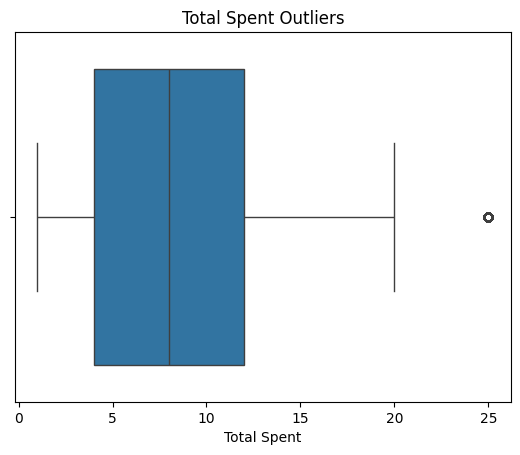

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['Total Spent'])
plt.title("Total Spent Outliers")
plt.show()

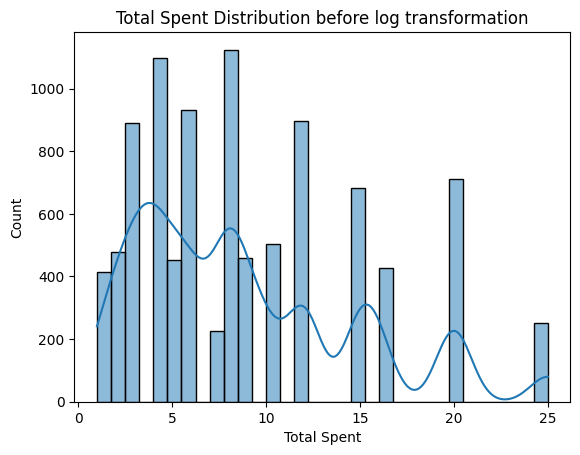

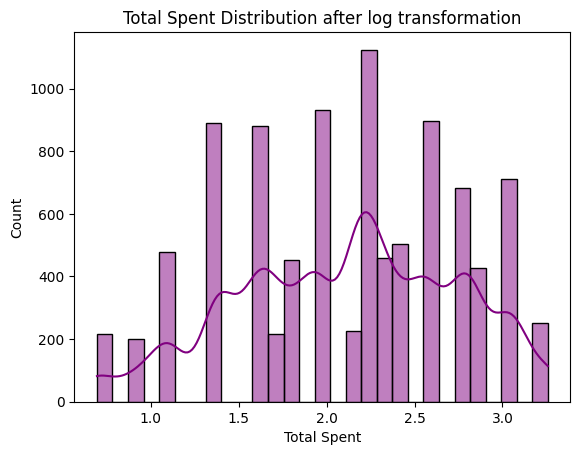

In [131]:
sns.histplot(df['Total Spent'], kde=True)
plt.title("Total Spent Distribution before log transformation")
plt.show()

df['Total Spent'] = np.log1p(df['Total Spent'])
plt.title("Total Spent Distribution after log transformation")
sns.histplot(df['Total Spent'], kde=True,color="purple")
plt.show()


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9540 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction ID                 9540 non-null   object        
 1   Quantity                       9540 non-null   float64       
 2   Price Per Unit                 9540 non-null   float64       
 3   Total Spent                    9540 non-null   float64       
 4   Transaction Date               9540 non-null   datetime64[ns]
 5   Payment Method_CREDIT CARD     9540 non-null   bool          
 6   Payment Method_DIGITAL WALLET  9540 non-null   bool          
 7   Location_TAKEAWAY              9540 non-null   bool          
 8   Item_COFFEE                    9540 non-null   bool          
 9   Item_COOKIE                    9540 non-null   bool          
 10  Item_JUICE                     9540 non-null   bool          
 11  Item_SALAD            

In [133]:
missing = pd.date_range(df.index.min(), df.index.max()).difference(df.index)
print("Missing dates:", len(missing))
print(f'duplicate check:{df.index.duplicated().sum()}')

Missing dates: 1
duplicate check:0


In [134]:
df = df.sort_values('Transaction Date')
df.set_index('Transaction Date', inplace=True)

daily_sales = df['Total Spent'].resample('D').sum()

In [135]:
df.drop(columns=['Transaction ID'], inplace=True)
df.head(10)

,Quantity,Price Per Unit,Total Spent,Payment Method_CREDIT CARD,Payment Method_DIGITAL WALLET,Location_TAKEAWAY,Item_COFFEE,Item_COOKIE,Item_JUICE,Item_SALAD,Item_SANDWICH,Item_SMOOTHIE,Item_TEA
Transaction Date,,,,,,,,,,,,,
2023-01-01,1.0,3.0,1.386294,False,True,True,False,False,True,False,False,False,False
2023-01-01,2.0,4.0,2.197225,False,True,False,False,False,False,False,False,True,False
2023-01-01,5.0,1.5,2.197225,False,True,True,False,False,False,False,False,False,True
2023-01-01,5.0,3.0,3.044522,False,True,False,False,False,False,False,True,False,False
2023-01-01,5.0,3.0,2.772589,False,True,True,False,False,True,False,False,False,False
2023-01-01,4.0,3.0,2.564949,False,True,True,False,False,True,False,False,False,False
2023-01-01,3.0,5.0,2.397895,False,True,True,False,False,False,True,False,False,False
2023-01-01,5.0,4.0,3.044522,False,False,False,False,False,False,False,True,False,False
2023-01-01,3.0,1.5,1.704748,False,True,False,False,False,False,False,False,False,True


In [137]:
import pandas as pd

# Assume df is your DataFrame
# 'Transaction Date' is already the index, so we access it via df.index
# df['Transaction Date'] = pd.to_datetime(df['Transaction Date']) # This line is no longer needed

# Extract day of year
df['DayOfYear'] = df.index.dayofyear

# Extract month
df['Month'] = df.index.month

# Optional: extract day of month and weekday
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday  # Monday=0

In [138]:
daily_sales = df.groupby('Transaction Date').agg({'Total Spent':'sum'}).reset_index()
daily_sales.set_index('Transaction Date', inplace=True)

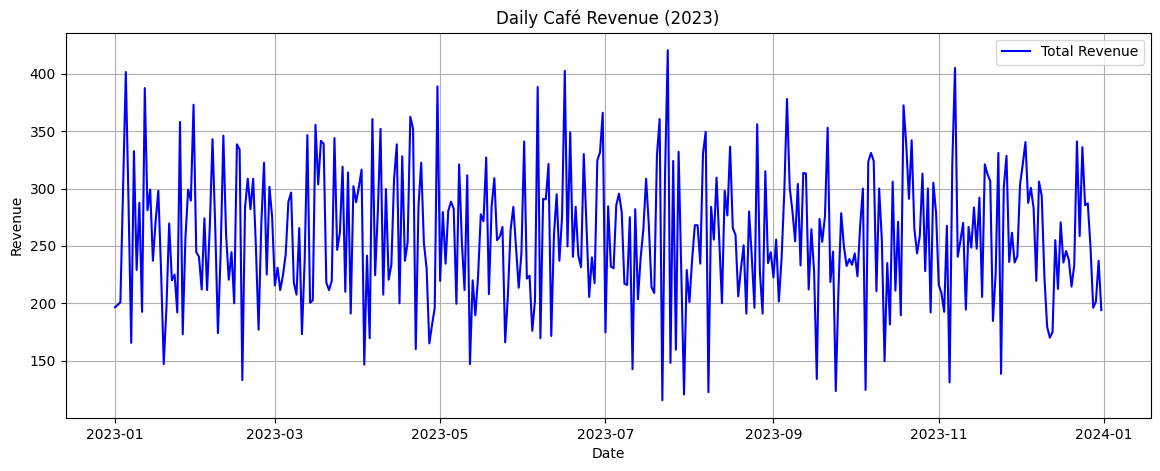

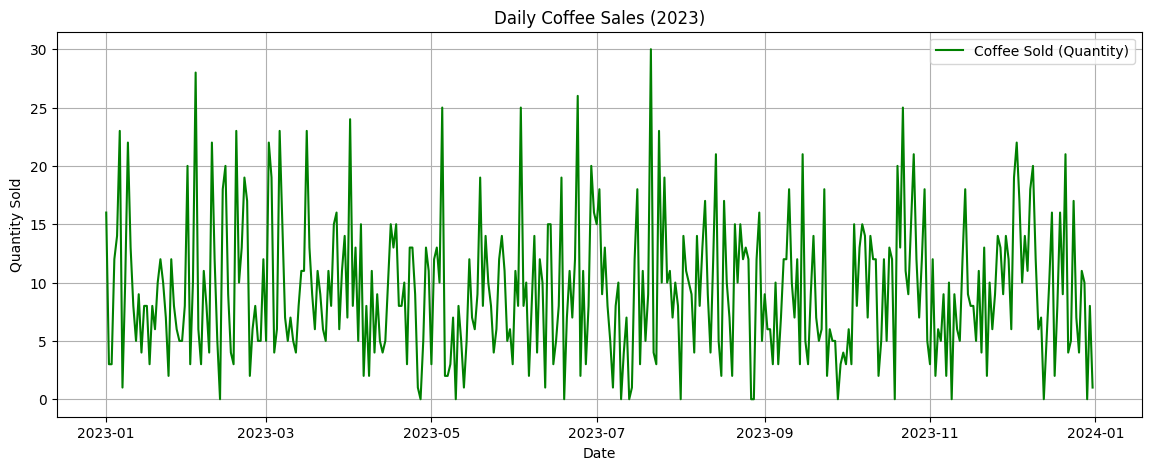

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Convert log revenue back to actual revenue
# -------------------------------
df['Total Spent'] = np.exp(df['Total Spent'])

# -------------------------------
# 2. Ensure 'Transaction Date' is a column
# -------------------------------
if 'Transaction Date' not in df.columns and df.index.name == 'Transaction Date':
    df.reset_index(inplace=True)

# -------------------------------
# 3. Convert to datetime and sort
# -------------------------------
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df = df.sort_values('Transaction Date')
df.set_index('Transaction Date', inplace=True)

# -------------------------------
# 4. Aggregate daily sales
# -------------------------------
daily_sales = df['Total Spent'].resample('D').sum()

# -------------------------------
# 5. Aggregate daily coffee quantity
# -------------------------------
coffee_daily = df[df['Item_COFFEE'] == True]['Quantity'].resample('D').sum().fillna(0)

# -------------------------------
# 6. Plot total daily revenue
# -------------------------------
plt.figure(figsize=(14,5))
plt.plot(daily_sales, color='blue', label='Total Revenue')
plt.title("Daily Café Revenue (2023)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# 7. Plot daily coffee sales
# -------------------------------
plt.figure(figsize=(14,5))
plt.plot(coffee_daily, color='green', label='Coffee Sold (Quantity)')
plt.title("Daily Coffee Sales (2023)")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipython-input-3737002870.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Total Spent'].resample('M').sum()


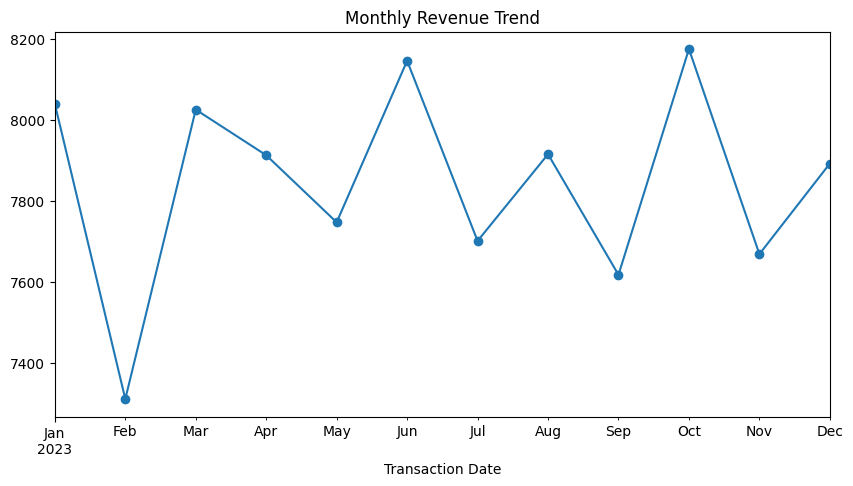

day_name
Friday        9.835735
Monday        9.799928
Saturday      9.818851
Sunday        9.874275
Thursday      9.958333
Tuesday      10.120519
Wednesday     9.680835
Name: Total Spent, dtype: float64


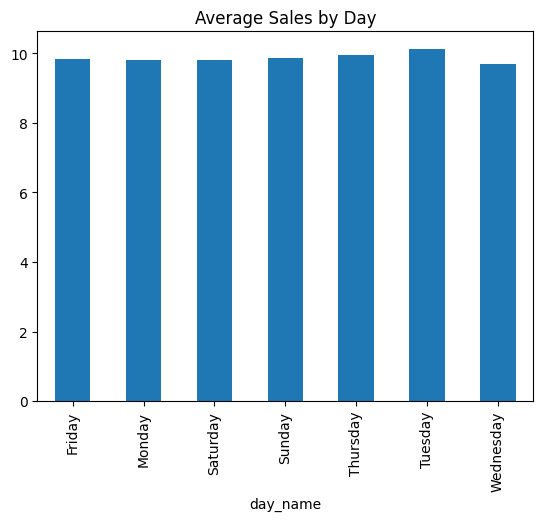

In [140]:
monthly_sales = df['Total Spent'].resample('M').sum()

monthly_sales.plot(marker='o', figsize=(10,5))
plt.title("Monthly Revenue Trend")
plt.show()

df['day_name'] = df.index.day_name()

weekday_sales = df.groupby('day_name')['Total Spent'].mean()
print(weekday_sales)

weekday_sales.plot(kind='bar')
plt.title("Average Sales by Day")
plt.show()

Missing dates: 0
check null value:0
outlier checking:


<Axes: >

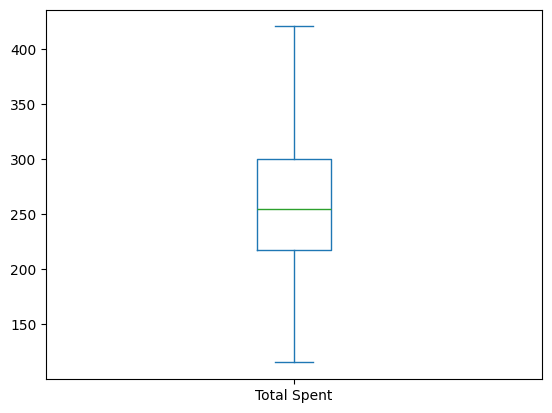

In [141]:
missing = pd.date_range(df.index.min(), df.index.max()).difference(df.index)
print("Missing dates:", len(missing))

print(f'check null value:{daily_sales.isna().sum()}')

# check outlier
print('outlier checking:')
daily_sales.plot.box()

In [142]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf

print("========== TIME SERIES DIAGNOSTIC REPORT ==========\n")

# ensure daily aggregation
ts = df['Total Spent'].resample('D').sum().fillna(0)

# -------------------------------
# 1. BASIC STRUCTURE
# -------------------------------
print("1️⃣ BASIC STRUCTURE")
print("Total observations:", len(ts))
print("Date range:", ts.index.min(), "to", ts.index.max())

missing_dates = pd.date_range(ts.index.min(), ts.index.max()).difference(ts.index)
print("Missing dates:", len(missing_dates))

duplicates = ts.index.duplicated().sum()
print("Duplicate dates:", duplicates)

# Interpretation
if len(missing_dates)==0 and duplicates==0:
    print("✔ Time continuity: GOOD\n")
else:
    print("⚠ Fix missing/duplicate dates\n")

# -------------------------------
# 2. MISSING VALUES
# -------------------------------
print("2️⃣ MISSING VALUES")
print("Missing values:", ts.isna().sum())

if ts.isna().sum()==0:
    print("✔ No missing values\n")
else:
    print("⚠ Fill missing values\n")

# -------------------------------
# 3. OUTLIER CHECK (IQR METHOD)
# -------------------------------
print("3️⃣ OUTLIERS")
q1, q3 = ts.quantile([0.25, 0.75])
iqr = q3 - q1
upper = q3 + 1.5 * iqr
outliers = (ts > upper).sum()

print("Outliers:", outliers)
print("Percent outliers:", round(outliers/len(ts)*100,2), "%")

if outliers/len(ts) < 0.05:
    print("✔ Outliers acceptable\n")
else:
    print("⚠ Many outliers — consider capping\n")

# -------------------------------
# 4. TREND STRENGTH
# -------------------------------
print("4️⃣ TREND STRENGTH")
trend_strength = ts.corr(pd.Series(range(len(ts)), index=ts.index))
print("Trend correlation:", round(trend_strength,3))

if abs(trend_strength) < 0.3:
    print("✔ Weak trend")
elif abs(trend_strength) < 0.6:
    print("✔ Moderate trend")
else:
    print("✔ Strong trend")
print()

# -------------------------------
# 5. WEEKLY SEASONALITY
# -------------------------------
print("5️⃣ WEEKLY SEASONALITY")
weekly_var = ts.groupby(ts.index.dayofweek).mean().std()
overall_var = ts.std()

seasonality_strength = weekly_var / overall_var
print("Seasonality strength:", round(seasonality_strength,3))

if seasonality_strength > 0.25:
    print("✔ Strong weekly seasonality\n")
else:
    print("✔ Weak weekly seasonality\n")

# -------------------------------
# 6. STATIONARITY (ADF TEST)
# -------------------------------
print("6️⃣ STATIONARITY (ADF TEST)")
adf_result = adfuller(ts)
p_value = adf_result[1]
print("ADF p-value:", round(p_value,4))

if p_value < 0.05:
    print("✔ Stationary (ARIMA ready)\n")
else:
    print("⚠ Non-stationary → differencing recommended\n")

# -------------------------------
# 7. AUTOCORRELATION
# -------------------------------
print("7️⃣ AUTOCORRELATION")
acf_vals = acf(ts, nlags=7)
autocorr_strength = acf_vals[1]

print("Lag-1 autocorrelation:", round(autocorr_strength,3))

if autocorr_strength > 0.5:
    print("✔ Strong dependence on previous day\n")
elif autocorr_strength > 0.2:
    print("✔ Moderate dependence\n")
else:
    print("✔ Weak dependence\n")

# -------------------------------
# 8. VOLATILITY LEVEL
# -------------------------------
print("\n8️⃣ VOLATILITY")
cv = ts.std() / ts.mean()
print("Coefficient of Variation:", round(cv,3))

if cv < 0.3:
    print("✔ Stable series")
elif cv < 0.6:
    print("✔ Moderate variability")
else:
    print("⚠ Highly volatile data")

print("\n========== DIAGNOSTIC COMPLETE ==========")

========== TIME SERIES DIAGNOSTIC REPORT ==========

1️⃣ BASIC STRUCTURE
Total observations: 365
Date range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Missing dates: 0
Duplicate dates: 0
✔ Time continuity: GOOD

2️⃣ MISSING VALUES
Missing values: 0
✔ No missing values

3️⃣ OUTLIERS
Outliers: 0
Percent outliers: 0.0 %
✔ Outliers acceptable

4️⃣ TREND STRENGTH
Trend correlation: -0.023
✔ Weak trend

5️⃣ WEEKLY SEASONALITY
Seasonality strength: 0.085
✔ Weak weekly seasonality

6️⃣ STATIONARITY (ADF TEST)
ADF p-value: 0.0
✔ Stationary (ARIMA ready)

7️⃣ AUTOCORRELATION
Lag-1 autocorrelation: -0.087
✔ Weak dependence


8️⃣ VOLATILITY
Coefficient of Variation: 0.226
✔ Stable series

========== DIAGNOSTIC COMPLETE ==========


In [143]:
import pandas as pd
import numpy as np

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("========= IMPROVED FORECAST MODEL COMPARISON =========\n")

# -----------------------------
# 1. PREPARE DAILY SERIES
# -----------------------------
ts = df['Total Spent'].resample('D').sum().fillna(0)

# -----------------------------
# 2. TRAIN / TEST SPLIT
# -----------------------------
train = ts[:-14]
test = ts[-14:]

print("Training days:", len(train))
print("Testing days:", len(test))

# -----------------------------
# 3. DEFINE METRICS FUNCTION
# -----------------------------
def evaluate(actual, forecast, name):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    print(name)
    print(" MAE :", round(mae,2))
    print(" RMSE:", round(rmse,2))
    print(" MAPE:", round(mape,2), "%")
    print("-----------------------")
    return mae

# -----------------------------
# 4. MODEL 1 — SES (Baseline)
# -----------------------------
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(14)

# -----------------------------
# 5. MODEL 2 — HOLT-WINTERS (Weekly Seasonality)
# -----------------------------
hw_model = ExponentialSmoothing(
    train,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

hw_forecast = hw_model.forecast(14)

# -----------------------------
# 6. MODEL 3 — SARIMA (Seasonal)
# -----------------------------
sarima_model = SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_forecast = sarima_model.forecast(14)

# -----------------------------
# 7. MODEL 4 — NAIVE BASELINE
# -----------------------------
naive_forecast = np.repeat(train.iloc[-1], 14)

# -----------------------------
# 8. COMPARE ACCURACY
# -----------------------------
print("\nMODEL ACCURACY")
print("=================")

ses_mae = evaluate(test, ses_forecast, "SES (Baseline)")
hw_mae = evaluate(test, hw_forecast, "Holt-Winters (Weekly)")
sarima_mae = evaluate(test, sarima_forecast, "SARIMA Seasonal")
naive_mae = evaluate(test, naive_forecast, "Naive")

# -----------------------------
# 9. SELECT BEST MODEL
# -----------------------------
mae_scores = {
    "SES": ses_mae,
    "Holt-Winters": hw_mae,
    "SARIMA": sarima_mae,
    "Naive": naive_mae
}

best_model = min(mae_scores, key=mae_scores.get)

print("\n🏆 BEST MODEL:", best_model)

# -----------------------------
# 10. FORECAST NEXT 7 DAYS USING BEST MODEL
# -----------------------------
if best_model == "SES":
    future_forecast = ses_model.forecast(7)
elif best_model == "Holt-Winters":
    future_forecast = hw_model.forecast(7)
elif best_model == "SARIMA":
    future_forecast = sarima_model.forecast(7)
else:
    future_forecast = np.repeat(train.iloc[-1], 7)

print("\n====== NEXT 7 DAYS FORECAST ======")
print(pd.Series(future_forecast, index=pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=7)).round(2))

# -----------------------------
# 11. SHOW ACTUAL vs BEST FORECAST (NUMBERS)
# -----------------------------
if best_model == "SES":
    best_forecast = ses_forecast
elif best_model == "Holt-Winters":
    best_forecast = hw_forecast
elif best_model == "SARIMA":
    best_forecast = sarima_forecast
else:
    best_forecast = naive_forecast

comparison = pd.DataFrame({
    "Actual": test,
    "Forecast": best_forecast
})

comparison["Absolute Error"] = (comparison["Actual"] - comparison["Forecast"]).abs()
comparison["Percent Error"] = (comparison["Absolute Error"] / comparison["Actual"]) * 100

print("\n====== BEST MODEL DAILY COMPARISON ======")
print(comparison.round(2))

========= IMPROVED FORECAST MODEL COMPARISON =========

Training days: 351
Testing days: 14

MODEL ACCURACY
SES (Baseline)
 MAE : 36.8
 RMSE: 45.32
 MAPE: 14.81 %
-----------------------
Holt-Winters (Weekly)
 MAE : 38.06
 RMSE: 46.3
 MAPE: 15.62 %
-----------------------
SARIMA Seasonal
 MAE : 39.33
 RMSE: 46.31
 MAPE: 16.16 %
-----------------------
Naive
 MAE : 35.46
 RMSE: 47.88
 MAPE: 13.26 %
-----------------------

🏆 BEST MODEL: Naive

====== NEXT 7 DAYS FORECAST ======
2024-01-01    235.5
2024-01-02    235.5
2024-01-03    235.5
2024-01-04    235.5
2024-01-05    235.5
2024-01-06    235.5
2024-01-07    235.5
Freq: D, dtype: float64

====== BEST MODEL DAILY COMPARISON ======
                  Actual  Forecast  Absolute Error  Percent Error
Transaction Date                                                 
2023-12-18         245.5     235.5            10.0           4.07
2023-12-19         238.0     235.5             2.5           1.05
2023-12-20         214.5     235.5            2

Total days: 365
Date range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00


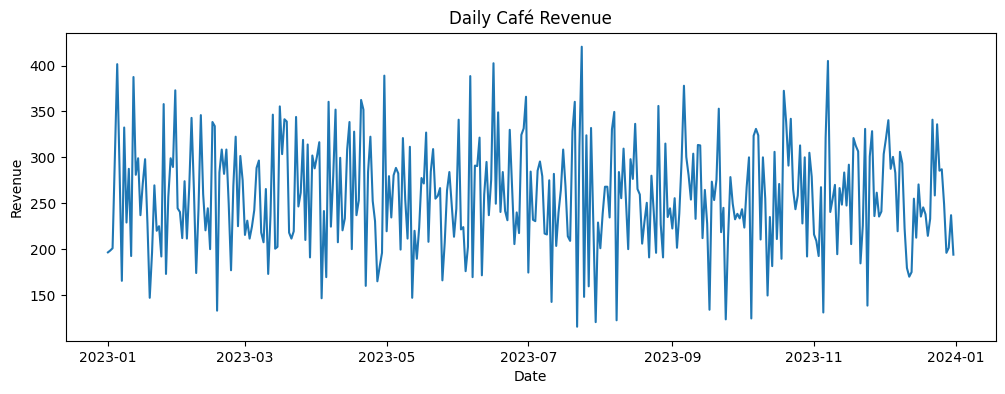

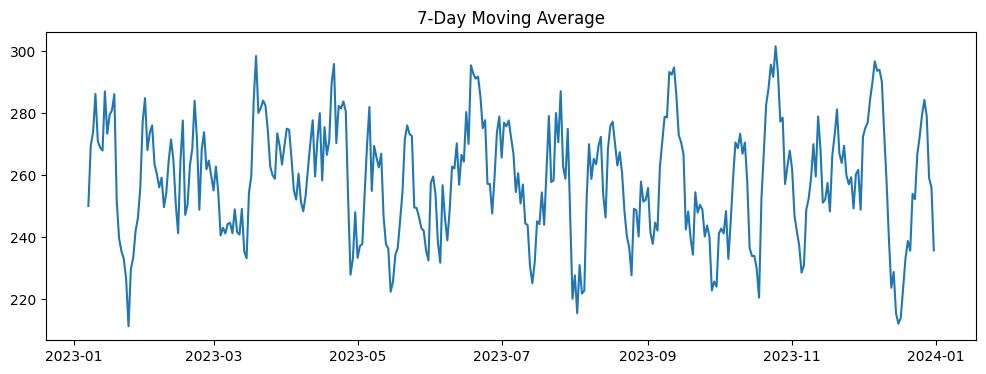


Training days: 351
Testing days: 14

MODEL ACCURACY COMPARISON
Naive
 MAE  = 35.46
 RMSE = 47.88
--------------------------------
Moving Average
 MAE  = 44.39
 RMSE = 58.55
--------------------------------
Holt-Winters
 MAE  = 37.62
 RMSE = 46.06
--------------------------------
ARIMA
 MAE  = 38.17
 RMSE = 45.82
--------------------------------


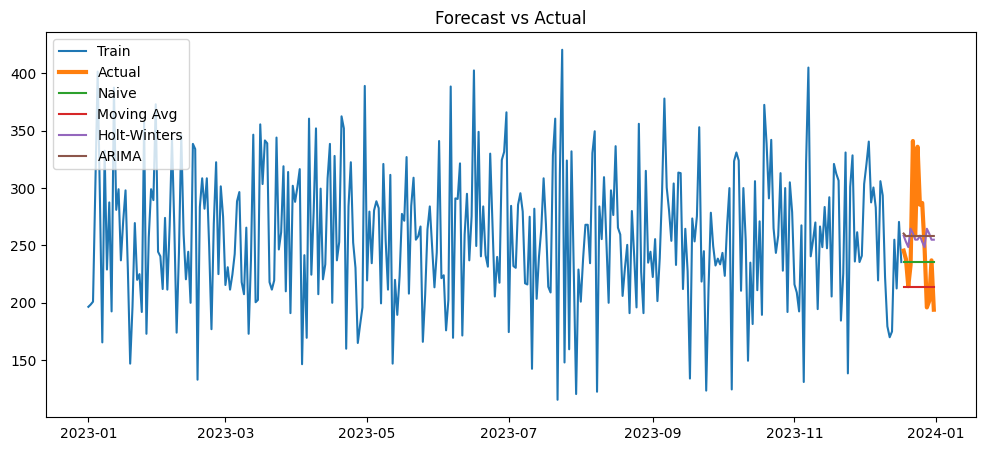


Best Model: ARIMA


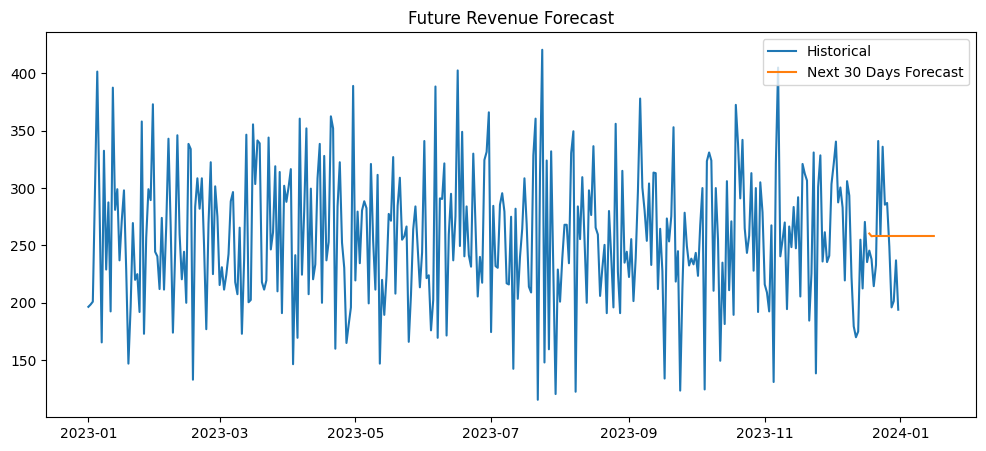

In [ ]:
 # ============================================================
# CAFE SALES FORECASTING USING DAILY REVENUE
# (BASED ON YOUR CURRENT DATA STRUCTURE)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# ------------------------------------------------------------
# 1. CREATE DAILY TIME SERIES FROM TRANSACTIONS
# ------------------------------------------------------------

# ensure sorted
df = df.sort_index()

# aggregate total revenue per day
daily_sales = df['Total Spent'].resample('D').sum()

# fill missing days
daily_sales = daily_sales.fillna(0)

print("Total days:", len(daily_sales))
print("Date range:", daily_sales.index.min(), "to", daily_sales.index.max())

# ------------------------------------------------------------
# 2. VISUALIZE TREND
# ------------------------------------------------------------

plt.figure(figsize=(12,4))
plt.plot(daily_sales)
plt.title("Daily Café Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# 7-day moving average (trend)
plt.figure(figsize=(12,4))
plt.plot(daily_sales.rolling(7).mean())
plt.title("7-Day Moving Average")
plt.show()

# ------------------------------------------------------------
# 3. TRAIN / TEST SPLIT
# ------------------------------------------------------------

forecast_days = 14

train = daily_sales[:-forecast_days]
test = daily_sales[-forecast_days:]

print("\nTraining days:", len(train))
print("Testing days:", len(test))

# ------------------------------------------------------------
# 4. MODEL 1 — NAIVE FORECAST
# ------------------------------------------------------------

naive_forecast = np.repeat(train.iloc[-1], forecast_days)

# ------------------------------------------------------------
# 5. MODEL 2 — MOVING AVERAGE
# ------------------------------------------------------------

moving_avg_value = train.rolling(7).mean().iloc[-1]
moving_avg_forecast = np.repeat(moving_avg_value, forecast_days)

# ------------------------------------------------------------
# 6. MODEL 3 — HOLT-WINTERS (BEST FOR DAILY BUSINESS DATA)
# ------------------------------------------------------------

hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=7   # weekly pattern
).fit()

hw_forecast = hw_model.forecast(forecast_days)

# ------------------------------------------------------------
# 7. MODEL 4 — ARIMA
# ------------------------------------------------------------

arima_model = ARIMA(train, order=(1,1,1)).fit()
arima_forecast = arima_model.forecast(forecast_days)

# ------------------------------------------------------------
# 8. ACCURACY METRICS
# ------------------------------------------------------------

def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

results = {}

results['Naive'] = evaluate(test, naive_forecast)
results['Moving Average'] = evaluate(test, moving_avg_forecast)
results['Holt-Winters'] = evaluate(test, hw_forecast)
results['ARIMA'] = evaluate(test, arima_forecast)

# ------------------------------------------------------------
# 9. PRINT MODEL PERFORMANCE
# ------------------------------------------------------------

print("\nMODEL ACCURACY COMPARISON")
print("================================")

for model, (mae, rmse) in results.items():
    print(f"{model}")
    print(f" MAE  = {mae:.2f}")
    print(f" RMSE = {rmse:.2f}")
    print("--------------------------------")

# ------------------------------------------------------------
# 10. FORECAST COMPARISON PLOT
# ------------------------------------------------------------

plt.figure(figsize=(12,5))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', linewidth=3)

plt.plot(test.index, naive_forecast, label='Naive')
plt.plot(test.index, moving_avg_forecast, label='Moving Avg')
plt.plot(test.index, hw_forecast, label='Holt-Winters')
plt.plot(test.index, arima_forecast, label='ARIMA')

plt.legend()
plt.title("Forecast vs Actual")
plt.show()

# ------------------------------------------------------------
# 11. SELECT BEST MODEL & FORECAST NEXT 30 DAYS
# ------------------------------------------------------------

best_model_name = min(results, key=lambda x: results[x][1])
print("\nBest Model:", best_model_name)

if best_model_name == 'Holt-Winters':
    best_model = hw_model
elif best_model_name == 'ARIMA':
    best_model = arima_model
else:
    best_model = hw_model   # fallback

future_forecast = best_model.forecast(30)

plt.figure(figsize=(12,5))
plt.plot(daily_sales, label='Historical')
plt.plot(future_forecast, label='Next 30 Days Forecast')
plt.legend()
plt.title("Future Revenue Forecast")
plt.show()